# K-fold cross validation Analysis

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error
np.random.seed(42)

Here you would normaly get a "RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility" warning. You do not since we silenced the warning in the first cell. If you are interested read here
https://stackoverflow.com/questions/40845304/runtimewarning-numpy-dtype-size-changed-may-indicate-binary-incompatibility

In [3]:
def get_data_x_cube(n):
        
    x = np.random.uniform(0, 4, n)
    X = np.expand_dims(x, axis=-1)
    y = 3*(x-2)**3 + 0.1*np.random.normal(0, 1, n)
    Y = np.expand_dims(y, axis=-1)
    
    return X, Y

In [4]:
def get_data(n):
        
    x = np.random.uniform(0, 4, n)
    X = np.expand_dims(x, axis=-1)
    y = x + np.random.normal(0, 3, n)
    Y = np.expand_dims(y, axis=-1)
    
    return X, Y

In [5]:
def MSE(Y_pred, Y):
    Y_pred = np.asarray(Y_pred)
    Y = np.asarray(Y)
    
    n = Y.shape[0]
    
    return 1/n * np.sum(np.square(Y_pred - Y))

In [6]:
def k_fold_evaluation_MSE(classifier, X, Y, K=10):
    k_folds_X = np.asarray(np.split(X,K,axis=0))
    k_folds_Y = np.asarray(np.split(Y,K,axis=0))
    
    MSE_s = []
    for i in range(K):
        validation_fold_X = k_folds_X[i]
        validation_fold_Y = k_folds_Y[i]
        
        if i == 0: # first fold for validation 
            training_folds_X = k_folds_X[i+1:]
            training_folds_Y = k_folds_Y[i+1:]
        elif i == K-1: # last fold  for validation
            training_folds_X = k_folds_X[0:K-1]
            training_folds_Y = k_folds_Y[0:K-1]
        else:  # intermediate fold for validation, concatenate others. 
            training_folds_X = np.concatenate((k_folds_X[0:i],k_folds_X[i+1:]),axis = 0)
            training_folds_Y = np.concatenate((k_folds_Y[0:i],k_folds_X[i+1:]),axis = 0)
        
        # reshape to one coherent dataset 
        training_fold_X = np.reshape(training_folds_X,(-1,training_folds_X.shape[2]))
        training_fold_Y = np.reshape(training_folds_Y,(-1,training_folds_Y.shape[2]))
        
        classifier.fit(training_fold_X,training_fold_Y)
        
        Y_pred = classifier.predict(validation_fold_X)
        
        error = MSE(Y_pred, validation_fold_Y)
        
        MSE_s.append(error)
    return np.mean(MSE_s)


In [7]:
def k_fold_cv_ridge(X, Y, lambdas, K=10):
    average_MSE_s = []

    for lam in lambdas:
        c = Ridge(lam)
        average_error = k_fold_evaluation_MSE(c,X,Y,K)
        average_MSE_s.append(average_error)
        
    f, ax = plt.subplots()    
    ax.scatter(np.log(lambdas), np.log(average_MSE_s), label = "Validation Error",c="red")
    ax.plot(np.log(lambdas), np.log(average_MSE_s),c="red")
    ax.set_xlabel("log(lambda)")
    ax.set_ylabel("log(Error)")
    #plt.show()
    
    return average_MSE_s, ax

In [8]:
X, Y = get_data_x_cube(300)
X_train, Y_train = X[:100], Y[:100]
X_test, Y_test = X[101:], Y[101:]

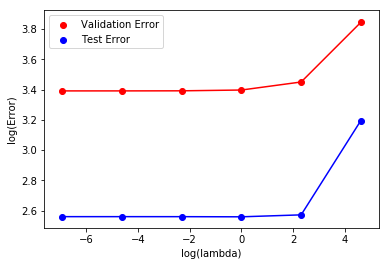

Validation Errors (log):  [ 3.39097248  3.39102464  3.39154646  3.39677947  3.4498114   3.84364773]
Test Errors (log):  [ 2.56081858  2.56080623  2.56068536  2.55973347  2.57261282  3.19496023]
Best performing lambda on Validation set:  0.001
Best performing lambda on Test set:  1


In [9]:
lambdas = [10**-3,10**-2,10**-1,1,10,100]
validation_MSE_s, ax = k_fold_cv_ridge(X_train, Y_train, lambdas)
test_MSE_s = []

for lam in lambdas:
    c = Ridge(lam)
    c.fit(X_train,Y_train)
    Y_pred = c.predict(X_test)
        
    error = MSE(Y_pred, Y_test)
    test_MSE_s.append(error)
    
ax.scatter(np.log(lambdas), np.log(test_MSE_s), label = "Test Error",c="blue")
ax.plot(np.log(lambdas), np.log(test_MSE_s),c="blue")
plt.legend()
plt.show()

print("Validation Errors (log): ", np.log(validation_MSE_s))
print("Test Errors (log): ", np.log(test_MSE_s))
print("Best performing lambda on Validation set: ", lambdas[np.argmin(validation_MSE_s)])
print("Best performing lambda on Test set: ", lambdas[np.argmin(test_MSE_s)])

We notice, that the Validation Error is overall higher than the test error and shows a similar pattern for lambda. Lambda values greater than one show an drastic increase in error (for validation and test error). The overall better performance for the test_set might result from the larger training set . 

In [10]:
X, Y = make_classification(n_samples=2000, n_features=2, n_informative=2, n_redundant=0, n_repeated=0, random_state=420)
X_train, Y_train = X[:100], Y[:100]
X_test, Y_test = X[101:], Y[101:]

In [11]:
ks = np.arange(1,11)
parameters = {'n_neighbors': ks}
clf = GridSearchCV(KNeighborsClassifier(weights="uniform"), parameters)
clf.fit(X_train, Y_train)
accuracy_cv = clf.cv_results_['mean_train_score']

In [12]:
accuracy = np.zeros(len(ks))
    
for i, k in enumerate(ks):
        
    knn = KNeighborsClassifier(n_neighbors=k, weights="uniform")
    knn.fit(X_train, Y_train)
    accuracy[i] = knn.score(X_test, Y_test)

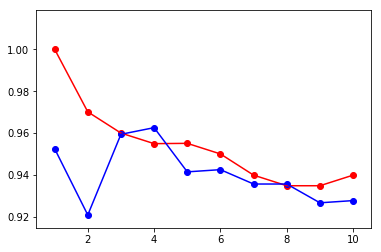

In [13]:
plt.figure()
plt.scatter(ks, accuracy_cv, c="red")
plt.plot(ks, accuracy_cv, c="red")
plt.scatter(ks, accuracy, c="blue")
plt.plot(ks, accuracy, c="blue")

In [14]:
accuracy_cv, accuracy

(array([ 1.        ,  0.9701426 ,  0.96004159,  0.95499109,  0.95513963,
         0.95008913,  0.93998812,  0.93493761,  0.93493761,  0.93998812]),
 array([ 0.95260664,  0.92101106,  0.95945234,  0.9626119 ,  0.94154818,
         0.94260137,  0.93575566,  0.93575566,  0.92680358,  0.92785677]))

The accuracy for the cross validated KNN overestimates the performance and overfits the data for small values of k and misses the best performing value of k = 4 on the test set. One problem in this approach is that the cross validated classifier is not trained in a real sense, but uses the training data for comparison. This leads to a strong dependance of the performance on the training data. Furthermore this also leads to a strong influence of the number of folds used in the cross validation, because the performance is calculated by taking the mean of each fold. Despite of the underlying math, another factor could be the metric used for evaluating the performance of the classifier.  

## Comparing different types of regressions

In [15]:
X, Y = get_data(400)
X_train, Y_train = X[:100], Y[:100]
X_test, Y_test = X[101:], Y[101:]

In [16]:
linear = LinearRegression()
linear.fit(X_train, Y_train)
Y_pred = linear.predict(X_test)
print("MSE: " + str(MSE(Y_pred, Y_test)))
print("log(MSE): " + str(np.log(MSE(Y_pred, Y_test))))

MSE: 9.48244514367
log(MSE): 2.24944220956


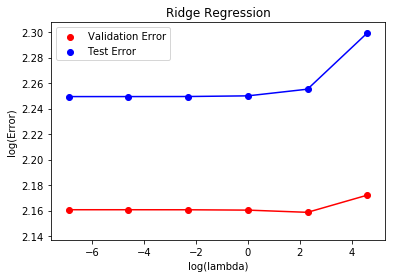

Validation Errors (log):  [ 2.16069046  2.16068765  2.16065959  2.16039017  2.15865658  2.17210924]
Test Errors (log):  [ 2.24944278  2.24944793  2.24949938  2.25001518  2.25525095  2.29928711]
Best performing lambda on Validation set:  10
Best performing lambda on Test set:  0.001


In [17]:
lambdas = [10**-3,10**-2,10**-1,1,10,100]
validation_MSE_s, ax = k_fold_cv_ridge(X_train, Y_train, lambdas)
test_MSE_s = []

for lam in lambdas:
    c = Ridge(lam)
    c.fit(X_train,Y_train)
    Y_pred = c.predict(X_test)
        
    error = MSE(Y_pred, Y_test)
    test_MSE_s.append(error)
    
ax.scatter(np.log(lambdas), np.log(test_MSE_s), label = "Test Error",c="blue")
ax.plot(np.log(lambdas), np.log(test_MSE_s),c="blue")
plt.legend()
plt.title("Ridge Regression")
plt.show()


print("Validation Errors (log): ", np.log(validation_MSE_s))
print("Test Errors (log): ", np.log(test_MSE_s))
print("Best performing lambda on Validation set: ", lambdas[np.argmin(validation_MSE_s)])
print("Best performing lambda on Test set: ", lambdas[np.argmin(test_MSE_s)])

The cross validation does not select the best possible $\lambda$. It selects $\lambda = 10$ by cross validation while the best performing $\lambda = 0.001$ on the test set.


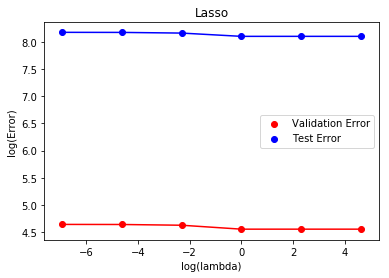

Validation Errors (log):  [ 4.63873016  4.63728709  4.62345686  4.55096338  4.55108615  4.55108615]
Test Errors (log):  [ 8.18133089  8.18003047  8.16759795  8.10724744  8.10738273  8.10738273]
Best performing lambda on Validation set:  1
Best performing lambda on Test set:  1


In [18]:
def k_fold_cv_lasso(X, Y, lambdas, K=10):
    average_MSE_s = []

    for lam in lambdas:
        c = Lasso(lam)
        average_error = k_fold_evaluation_MSE(c,X,Y,K)
        average_MSE_s.append(average_error)
        
    f, ax = plt.subplots()    
    ax.scatter(np.log(lambdas), np.log(average_MSE_s), label = "Validation Error",c="red")
    ax.plot(np.log(lambdas), np.log(average_MSE_s),c="red")
    ax.set_xlabel("log(lambda)")
    ax.set_ylabel("log(Error)")
    #plt.show()
    
    return average_MSE_s, ax

lambdas = [10**-3,10**-2,10**-1,1,10,100]
validation_MSE_s, ax = k_fold_cv_lasso(X_train, Y_train, lambdas)
test_MSE_s = []

for lam in lambdas:
    c = Lasso(lam)
    c.fit(X_train,Y_train)
    Y_pred = c.predict(X_test)
        
    error = MSE(Y_pred, Y_test)
    test_MSE_s.append(error)
    
ax.scatter(np.log(lambdas), np.log(test_MSE_s), label = "Test Error",c="blue")
ax.plot(np.log(lambdas), np.log(test_MSE_s),c="blue")
plt.legend()
plt.title("Lasso")
plt.show()

print("Validation Errors (log): ", np.log(validation_MSE_s))
print("Test Errors (log): ", np.log(test_MSE_s))
print("Best performing lambda on Validation set: ", lambdas[np.argmin(validation_MSE_s)])
print("Best performing lambda on Test set: ", lambdas[np.argmin(test_MSE_s)])

The cross validation selects the best possible $\lambda$. It selects $\lambda = 1$ on the validation set which is as well the best performing on the test set. 


Comparing both graphs we can see, that the ridge regression performs overall better than the lasso regression. Lasso has a larger discrepance between validation and test error. While the error in the ridge regression increases for $\lambda > 1$, it stays nearly the same in lasso regression. This might indicate that sparsity is not useful in our case, because reduces flexibility of the model. Another factor which comes in to play is the small size of the trainig data, which influences the choice of $\lambda$. While the cross validation for ridge regression suggests $\lambda = 10 $ which indicates that a simpler model is catching the underlying structure of the data, the results on the test set show that using a liberal $\lambda = 0.001$ performs better. 

Ridge Regression works best. Linear Regression works better than Lasso.